# Machine Learning Stuff
Kinda just for fun. Seeing if I can predict the wallet report response with some machine learning techniques.

In [26]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns

# Do we need this? This is added by chatgpt
from pandas.api.types import is_numeric_dtype

import numpy as np

from scipy.stats import chi2_contingency

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Data import

numeric_features_initial = [
    "general_trust",
    "GPS_trust",
    "general_morality",
    "MFQ_genmorality",
    "civic_cooperation",
    "GPS_posrecip",
    "GPS_altruism",
    "stranger1",
]

cat_cols = [
    "country",
    "response",
    "male",
    "above40",
    "computer",
    "coworkers",
    "other_bystanders",
    "institution",
    "cond",
    "security_cam",
    "security_guard",
    "local_recipient",
    "no_english",
    "understood_situation",
]

sc_measures = [
    "log_gdp",
    "log_tfp",
    "gee",
    "letter_grading",
]

# Import Tannenbaum data
df = pd.read_csv(
    "../data/tannenbaum_data.csv",
    dtype={col: "category" for col in cat_cols},
)

# Import PISA data
pisa = pd.read_csv("../data/pisa_data.csv").rename(columns={"mean_score": "pisa_score"})
df = df.merge(pisa, how="left", on="country")

## Exploratory Data Analysis (EDA)

Visualizing the distributions of individual features and their relationships.

### Feature Distributions

Histograms for continuous variables and bar plots for categorical variables.

In [8]:
def subplot_subset(data_frame, cols_to_plot, n_subplot_cols=4):
    """Make a grid of histograms or bar plots for specified columns."""
    if data_frame.empty or not cols_to_plot:
        print("Dataframe is empty or no columns to plot.")
        return
        
    n_features = len(cols_to_plot)
    n_rows = (n_features + n_subplot_cols - 1) // n_subplot_cols # Calculate number of rows needed
    
    fig = make_subplots(rows=n_rows, cols=n_subplot_cols, subplot_titles=cols_to_plot)
    
    for i, feature in enumerate(cols_to_plot):
        row_idx = (i // n_subplot_cols) + 1
        col_idx = (i % n_subplot_cols) + 1
        
        if pd.api.types.is_numeric_dtype(data_frame[feature]):
            fig.add_trace(
                go.Histogram(x=data_frame[feature], name=feature),
                row=row_idx,
                col=col_idx,
            )
        else: # Categorical
             # For bar plots, we need counts of each category
            counts = data_frame[feature].value_counts()
            fig.add_trace(
                go.Bar(x=counts.index, y=counts.values, name=feature),
                row=row_idx,
                col=col_idx,
            )
            
    fig.update_layout(title_text="Feature Distributions", height=300*n_rows, showlegend=False)
    fig.show()

if not df.empty:
    # Visualize first set of features (example)
    # The original script plots columns by index, which can be fragile.
    # It's better to explicitly list features or groups of features.
    print("Displaying distributions for numeric features:")
    subplot_subset(df, numeric_features_initial)
    
    # Example for some categorical features (excluding country and response for brevity here)
    categorical_subset_viz = [col for col in cat_cols if col not in ['country', 'response']][:8] # First 8 for example
    print("\nDisplaying distributions for a subset of categorical features:")
    subplot_subset(df, categorical_subset_viz)
    
    print("\nDisplaying distributions for social capital measures:")
    subplot_subset(df, sc_measures)

Displaying distributions for numeric features:



Displaying distributions for a subset of categorical features:



Displaying distributions for social capital measures:


### Generalized Association Matrix
To understand relationships between pairs of variables, we compute a generalized correlation matrix. This uses Pearson's correlation for numeric-numeric pairs, correlation ratio for numeric-categorical pairs, and Cramer's V for categorical-categorical pairs.

In [19]:
def cramers_v(ex, y_cramer):
    """Cramer correlation between two categorical variables."""
    # Ensure no NaN values, as crosstab will not handle them well for chi2
    ex_nona = ex.dropna()
    y_cramer_nona = y_cramer.dropna()
    # Align indices if they are different after dropping NaNs
    common_index = ex_nona.index.intersection(y_cramer_nona.index)
    ex_nona = ex_nona.loc[common_index]
    y_cramer_nona = y_cramer_nona.loc[common_index]
    
    if ex_nona.empty or y_cramer_nona.empty:
        return 0.0 # Or np.nan if preferred for empty inputs
        
    confusion_matrix = pd.crosstab(ex_nona, y_cramer_nona)
    if confusion_matrix.empty or confusion_matrix.shape[0] == 0 or confusion_matrix.shape[1] == 0:
        return 0.0
        
    chi2_cramers = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    if n == 0:
        return 0.0
        
    phi2 = chi2_cramers / n
    r, k = confusion_matrix.shape
    if min(k - 1, r - 1) == 0:
        return 0.0 # Avoid division by zero if a variable has only one category after filtering
    return np.sqrt(phi2 / min(k - 1, r - 1))

def correlation_ratio(values, categories):
    """Correlation ratio between a categorical and numeric variable."""
    na_mask = values.notna() & categories.notna()
    num_var = values[na_mask]
    cat_var = categories[na_mask]

    if num_var.empty or cat_var.empty or len(cat_var.unique()) < 2:
        return 0.0

    fcat, _ = pd.factorize(cat_var)
    cat_num = np.max(fcat) + 1
    y_avg = num_var.mean()

    numerator = sum(
        len(num_var[fcat == i]) * (num_var[fcat == i].mean() - y_avg) ** 2
        for i in range(cat_num) if len(num_var[fcat == i]) > 0
    )
    denominator = np.sum((num_var - y_avg) ** 2)

    return np.sqrt(numerator / denominator) if denominator != 0 else 0.0

if not df.empty:
    df_cols_assoc = df.columns.drop("country") # Excluding country for this matrix, can be too many categories
    assoc = pd.DataFrame(index=df_cols_assoc, columns=df_cols_assoc, dtype=float)

    for col1 in df_cols_assoc:
        for col2 in df_cols_assoc:
            if col1 == col2:
                assoc.loc[col1, col2] = 1.0
            elif is_numeric_dtype(df[col1]) and is_numeric_dtype(df[col2]):
                # Both numeric:
                corr_val = df[[col1, col2]].corr().iloc[0, 1]
                assoc.loc[col1, col2] = corr_val if pd.notna(corr_val) else 0.0
            elif is_numeric_dtype(df[col1]) and not is_numeric_dtype(df[col2]):
                # First numeric, second categorical:
                assoc.loc[col1, col2] = correlation_ratio(df[col1], df[col2])
            elif is_numeric_dtype(df[col2]) and not is_numeric_dtype(df[col1]):
                # First categorical, second numeric:
                assoc.loc[col1, col2] = correlation_ratio(df[col2], df[col1])
            else:
                # Both categorical:
                assoc.loc[col1, col2] = cramers_v(df[col1], df[col2])

    assoc = assoc.astype(float)

    fig_assoc = px.imshow(
        assoc,
        labels=dict(x="Features", y="Features", color="Association"),
        color_continuous_scale="RdBu_r",
        zmin=-1,
        zmax=1,
        aspect="auto",
    )
    fig_assoc.update_layout(title_text="Association Matrix (Generalized Correlation)", height=800)
    fig_assoc.show()
else:
    print("DataFrame is empty, skipping association matrix.")

### Pairplot for Numeric Features and Response
Visualizing relationships between numeric features, colored by the 'response' variable.

Displaying pairplot for numeric features, colored by response category.


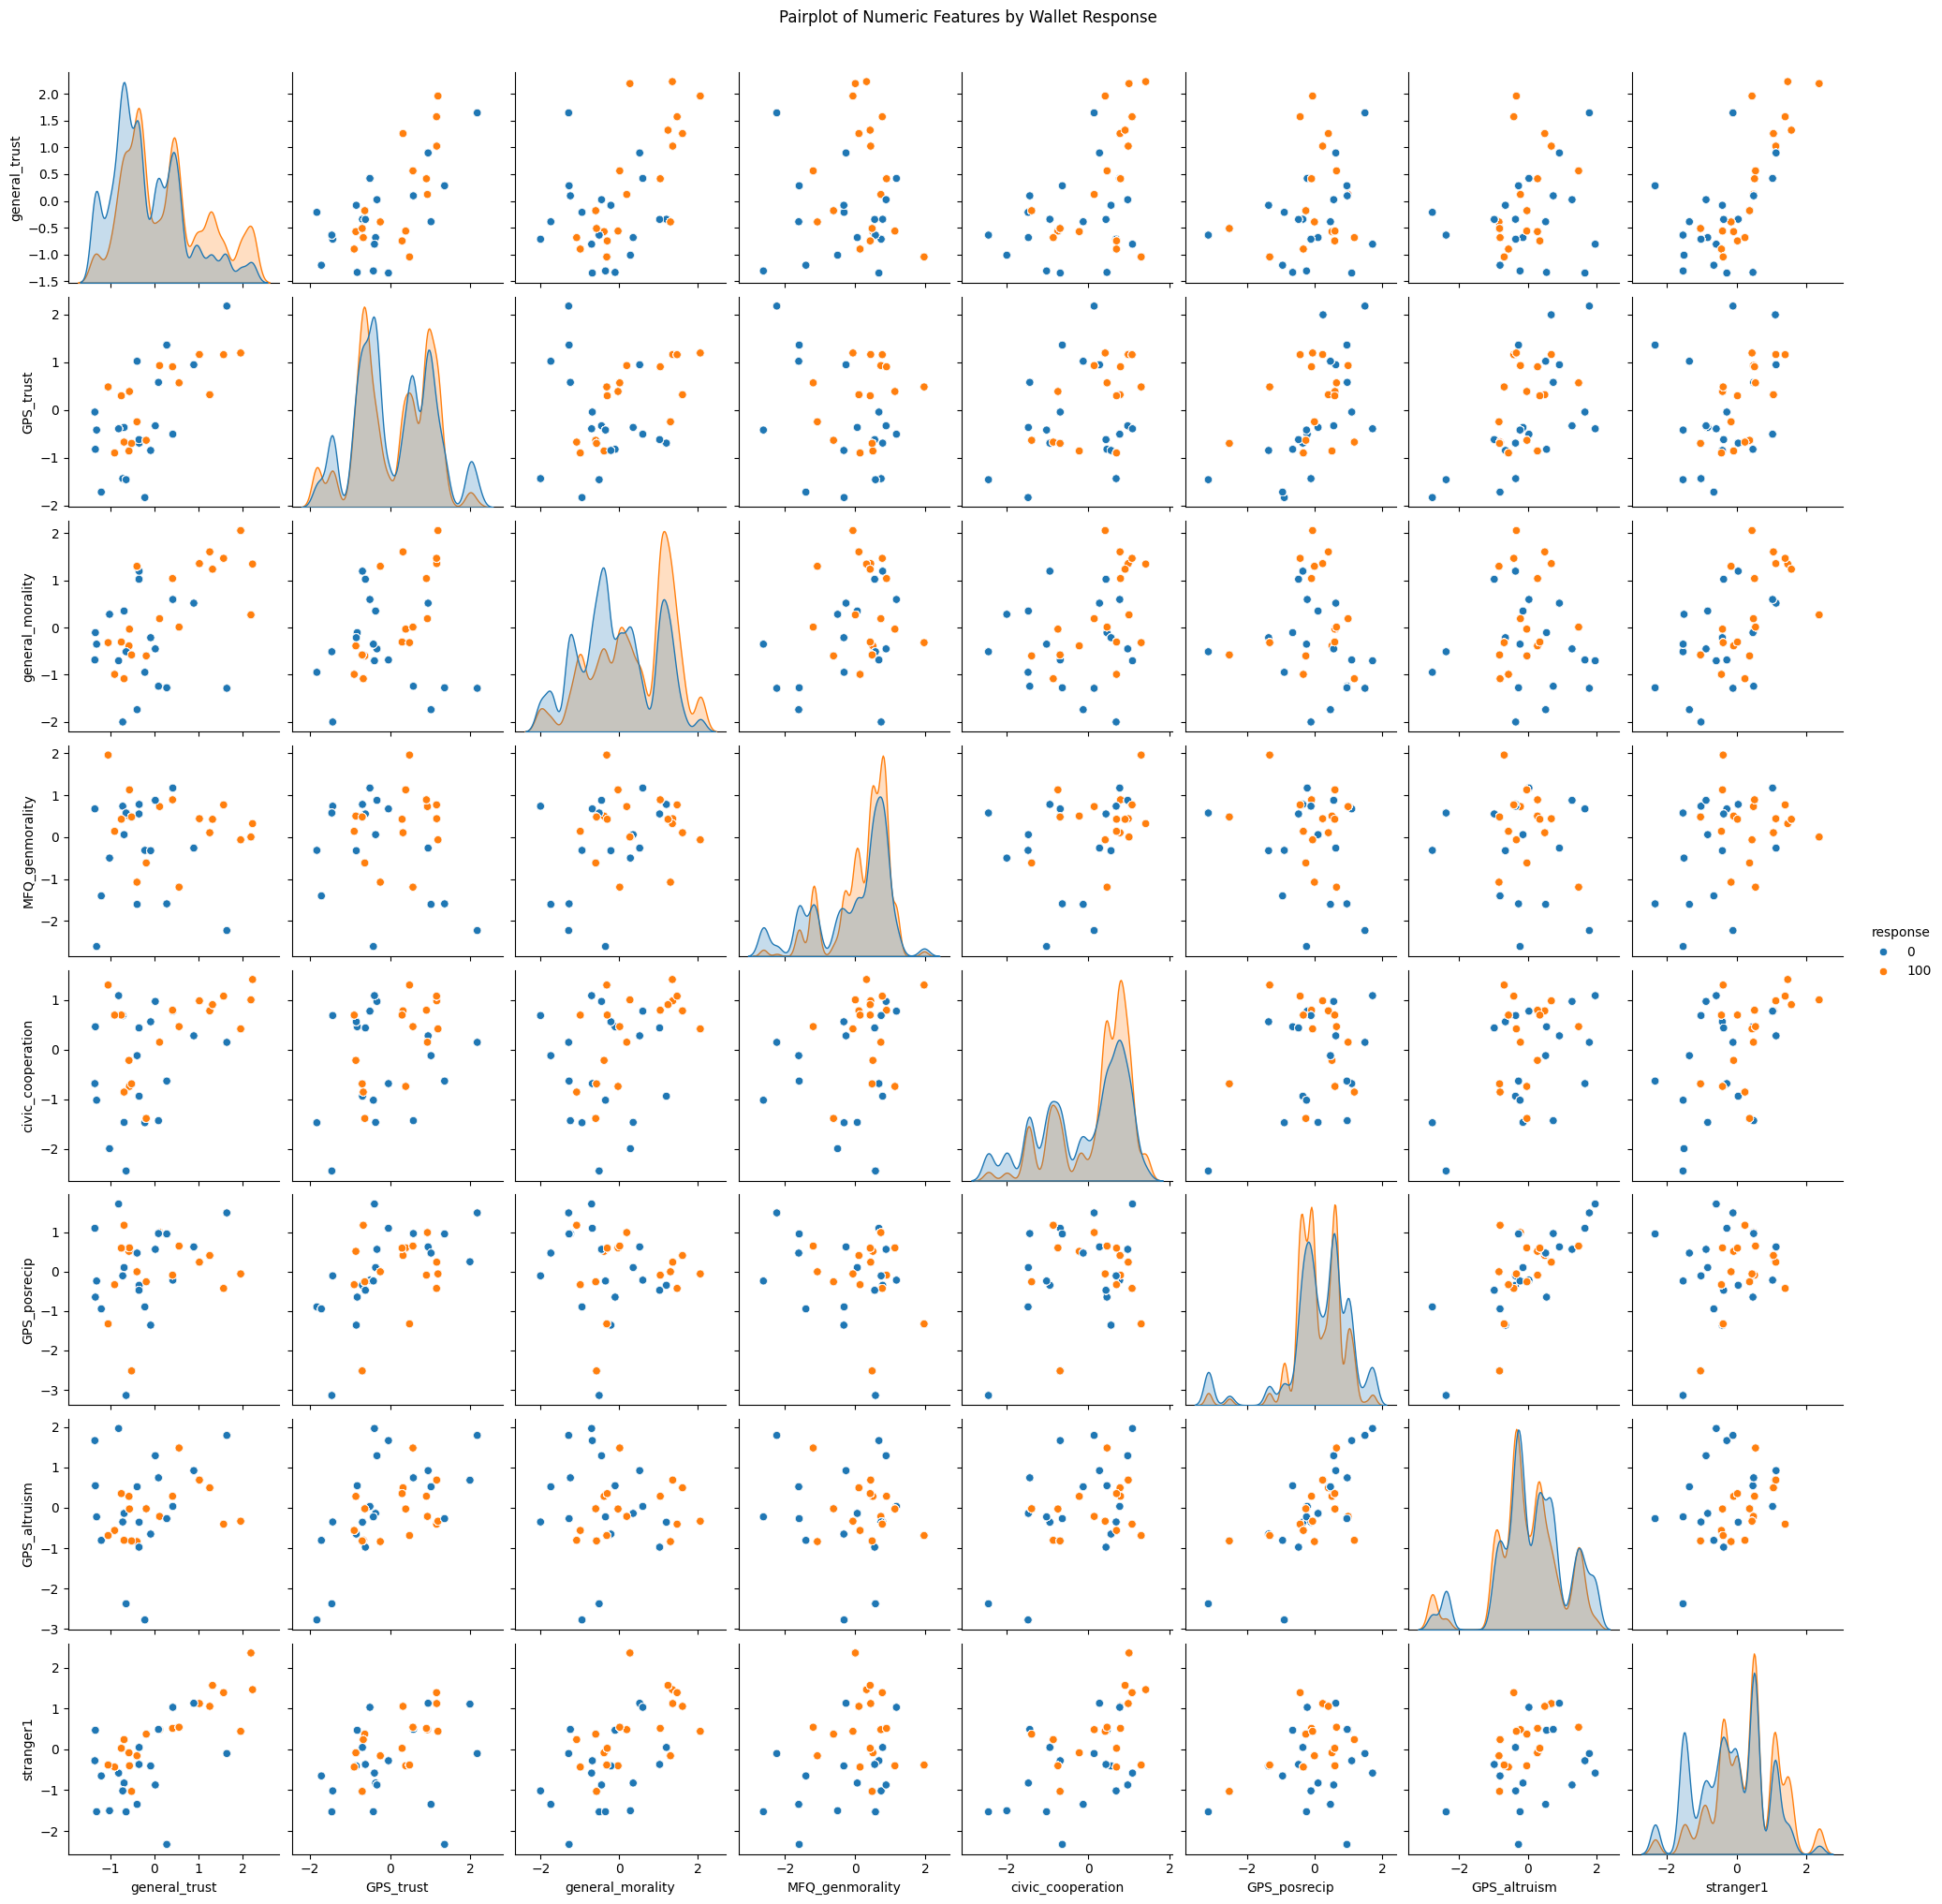

In [ ]:
# if not df.empty:
#     # Ensure 'response' is suitable for hue (categorical)
#     # If response is numeric (e.g. 0, 100), convert to string for distinct categories in pairplot hue
#     df_pairplot = df.copy()
#     if pd.api.types.is_numeric_dtype(df_pairplot['response']):
#          df_pairplot['response'] = df_pairplot['response'].astype(str)
    
#     print("Displaying pairplot for numeric features, colored by response category.")
#     # Adding a check for sufficient data points to avoid errors with pairplot
#     if len(df_pairplot) > 1 and len(numeric_features_initial) > 0:
#         pairplot_fig = sns.pairplot(df_pairplot[numeric_features_initial + ["response"]], hue="response", diag_kind='kde')
#         pairplot_fig.fig.suptitle("Pairplot of Numeric Features by Wallet Response", y=1.02)
#         # plt.show() # Use this if running in a local environment where seaborn doesn't auto-show
#     else:
#         print("Not enough data or numeric features to generate pairplot.")
# else:
#     print("DataFrame is empty, skipping pairplot.")

## Predicting Wallet Response

Building models to predict whether a wallet is reported based on various features. We'll first use the original features, then incorporate PISA scores to see if they improve predictive accuracy (at an individual prediction level, which is a different task than country-level prediction/correlation).

### Preprocessing and Model without PISA Data

In [27]:
if not df.empty:
    # Define features for this model
    numeric_features_ml1 = [
        "general_trust", "GPS_trust", "general_morality", "MFQ_genmorality",
        "civic_cooperation", "GPS_posrecip", "GPS_altruism", "stranger1"
    ]
    categorical_features_ml1 = [
        "male", "above40", "computer", "coworkers", "other_bystanders", 
        "institution", "cond"
        # Excluding other categorical features like security_cam, etc. as in original script for this part
    ]

    # Numeric feature pipeline
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

    # Categorical feature pipeline
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")), # Added imputer for categorical
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
            # SelectPercentile for categorical features after OHE might be less common than for numeric.
            # Chi2 requires non-negative features, which OHE provides.
            ("selector", SelectPercentile(chi2, percentile=50)) 
        ]
    )

    preprocessor1 = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features_ml1),
            ("cat", categorical_transformer, categorical_features_ml1),
        ]
    )

    # Target variable: needs to be numeric for scikit-learn classifiers
    # Assuming 'response' categories are '0' and '100'. We map them to 0 and 1.
    y = df["response"].cat.codes # This will map '0' to 0 and '100' to 1 if these are the categories
    X = df.drop(columns="response")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=23, stratify=y # Stratify by y for classification
    )

    # Example classifier: SVC (as in original script)
    # The original script tested various classifiers; SVC with class_weight='balanced' was highlighted.
    clf1 = Pipeline(
        steps=[
            ("preprocessor", preprocessor1),
            ("classifier", SVC(random_state=123, class_weight="balanced"))
        ]
    )

    # Weighting observations (as explored in original script)
    # This was an experiment; its effectiveness can vary.
    cond_counts = X_train["cond"].value_counts(normalize=True)
    weights = X_train["cond"].map(lambda x: 1 / cond_counts[x] if x in cond_counts else 1.0)

    try:
        clf1.fit(X_train, y_train, classifier__sample_weight=weights)
        score1 = clf1.score(X_test, y_test)
        print(f"Model 1 (without PISA) score: {score1:.3f}")
    except Exception as e:
        print(f"Error fitting Model 1: {e}")
        print("Check feature lists and preprocessor compatibility with selected classifier.")

else:
    print("DataFrame is empty, skipping ML model training.")

Model 1 (without PISA) score: 0.689


### Preprocessing and Model with PISA Data (and other SC measures)
Here, we add country-level PISA scores and other social capital measures (`sc_measures`) to the feature set. Note that PISA scores are country-level, so they will be constant for all individuals within the same country. This might limit their predictive power for individual responses but is included as per the original exploration.

In [28]:
if not df.empty and not pisa_reading_2022.empty:
    df_with_pisa = df.merge(pisa_reading_2022[['country', 'PISA_Avg_Reading_2022']], how="left", on="country")
    # Impute PISA scores if some countries in df don't have them (e.g., with mean PISA score)
    df_with_pisa['PISA_Avg_Reading_2022'] = df_with_pisa['PISA_Avg_Reading_2022'].fillna(df_with_pisa['PISA_Avg_Reading_2022'].mean())

    numeric_features_ml2 = numeric_features_initial + sc_measures + ['PISA_Avg_Reading_2022']
    # Ensure all numeric features actually exist in df_with_pisa and are numeric
    valid_numeric_features_ml2 = []
    for col in numeric_features_ml2:
        if col in df_with_pisa.columns and pd.api.types.is_numeric_dtype(df_with_pisa[col]):
            valid_numeric_features_ml2.append(col)
        elif col in df_with_pisa.columns: # If column exists but not numeric, try to convert
            df_with_pisa[col] = pd.to_numeric(df_with_pisa[col], errors='coerce')
            if pd.api.types.is_numeric_dtype(df_with_pisa[col]):
                 valid_numeric_features_ml2.append(col)
            else:
                print(f"Warning: Column '{col}' could not be converted to numeric and will be excluded from numeric features for ML.")
        else:
            print(f"Warning: Column '{col}' not found in dataframe and will be excluded from numeric features for ML.")
    numeric_features_ml2 = valid_numeric_features_ml2
    
    # Categorical features from original script for this model
    categorical_features_ml2 = [
        "male", "above40", "computer", "coworkers", "other_bystanders", 
        "institution", "cond", "security_cam", "security_guard", 
        "local_recipient", "no_english", "understood_situation"
    ]
    valid_categorical_features_ml2 = [col for col in categorical_features_ml2 if col in df_with_pisa.columns]
    categorical_features_ml2 = valid_categorical_features_ml2

    # Numeric transformer (can reuse the previous one if strategy is the same)
    numeric_transformer_ml2 = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

    # Categorical transformer (can reuse)
    categorical_transformer_ml2 = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ("selector", SelectPercentile(chi2, percentile=50)), 
        ]
    )

    preprocessor2 = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer_ml2, numeric_features_ml2),
            ("cat", categorical_transformer_ml2, categorical_features_ml2),
        ],
        remainder='drop' # Drop any columns not specified
    )

    # Target variable
    y2 = df_with_pisa["response"].cat.codes
    X2 = df_with_pisa.drop(columns="response")

    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X2, y2, test_size=0.2, random_state=23, stratify=y2
    )

    # Example classifier: RandomForest (as explored in original script)
    # The original script commented out RandomForest, let's try it or stick to SVC for comparison
    clf2 = Pipeline(
        steps=[
            ("preprocessor", preprocessor2),
            # ("classifier", SVC(random_state=123, class_weight="balanced")) 
            ("classifier", RandomForestClassifier(max_depth=8, random_state=0, class_weight="balanced"))
        ]
    )
    
    # Weighting (optional, as before)
    # cond_counts2 = X_train2["cond"].value_counts(normalize=True)
    # weights2 = X_train2["cond"].map(lambda x: 1 / cond_counts2[x] if x in cond_counts2 else 1.0)

    try:
        # clf2.fit(X_train2, y_train2, classifier__sample_weight=weights2) # If using weights
        if not X_train2.empty and len(numeric_features_ml2) + len(categorical_features_ml2) > 0:
            clf2.fit(X_train2, y_train2)
            score2 = clf2.score(X_test2, y_test2)
            print(f"Model 2 (with PISA & SC measures) score: {score2:.3f}")
        else:
            print("Skipping Model 2 fitting due to no valid features or empty training data.")
    except Exception as e:
        print(f"Error fitting Model 2: {e}")
        print(f"Numeric features used: {numeric_features_ml2}")
        print(f"Categorical features used: {categorical_features_ml2}")
        print("Check feature lists, data types, and preprocessor compatibility.")
else:
    print("DataFrame or PISA data is empty, skipping ML model training with PISA features.")

NameError: name 'pisa_reading_2022' is not defined

### Commentary on Machine Learning Results

Using a comprehensive set of variables (experiment variables, survey measures, economic/institutional performance measures, PISA scores), the predictive accuracy for individual wallet responses did not dramatically improve, typically hovering around 0.68 - 0.70 (depending on the model and specific run, the original script mentioned ~0.687). 

This level of accuracy is somewhat expected. Predicting individual acts of honesty with high precision based on available (mostly demographic or country-level) data is inherently challenging. Individual behavior is complex and influenced by many immediate situational factors not captured in these datasets.